# 6.S083 / 18.S190 Spring 2020: Problem set 4

Submission deadline: Tuesday April 28, 2020 at 11:59pm.


In this problem set, we will look at the simplest epidemic model in which
we take **space** into account.

The simplest way to do this is to use **discrete space**: each agent lives
in a cell of a square grid. For simplicity in the coding we will not allow more
than one agent in any one grid cell, but this means that we need to carefully
design the rules of the model to respect this.

The effect of space is thus to *restrict* the set of other agents with which
a given agent can interact at any one time. (Compare the previous Problem Set,
in which any agent could interact with any other.)


## Exercise 1: Moving in 2D

In this exercise we will implement a random walk on a 2D lattice (grid).

1. Define an abstract type `AbstractWalker`.

2. Define an abstract type `Abstract2DWalker` that is a subtype of `AbstractWalker` (using  `<:`).

3. Define an immutable type `Location` that contains integers `x` and `y`.

4. Define a `Walker2D` type that is a subtype of `AbstractWalker2D`. It should contain a field `position` that is a `Location` object.

5. Check that Julia automatically provides a constructor function `Walker2D(position)` that accepts an object of type `Location`.

    Construct a `Walker` located at the origin.

6. Write a new method of the constructor for `Walker2D` that accepts two integers, $x$ and $y$, i.e. `Walker2D(x, y)`.

7. Write a function `make_tuple` that takes an object of type `Location` and returns the corresponding tuple
`(x, y)`.



In the following questions, the functions should take an object of type `AbstractWalker2D`
(or you can just leave them untyped).

8. Write a getter function `pos` that returns the position as a `Location` object.

9. Write a setter function `set_pos!` that sets the position to a given location `l`.

10. Write a function `jump` that returns a possible new position for a walker after a 2D jump
as a `Location` object. This function should *not* modify its argument,
and hence does not have a `!` in its name.

    Jumps are equally likely in the directions right, up, left and down.

    A nice way to implement this is to make a tuple `neighbours` of possible
    destinations.

11. Write a function `jump!` that moves a walker to a new position. What arguments does the function need? Use your `jump` function to write `jump!`.

12. Write a function `trajectory` that calculates a trajectory of a 2D walker of length $N$.

13. Plot 10 trajectories of length 10,000 on a single figure, all starting at the origin.

    Note that `Plots.jl` can accept a `Vector` of `Tuple`s, i.e. $(x, y)$ pairs, as the coordinates to plot.

In [1]:
abstract type AbstractWalker end

In [2]:
abstract type Abstract2DWalker <: AbstractWalker end

In [3]:
struct Location
    x::Int64
    y::Int64
end

In [4]:
mutable struct Walker2D <: Abstract2DWalker
    position::Location
end

In [5]:
origin = Location(0,0)
Walker2D(origin)

Walker2D(Location(0, 0))

In [6]:
function Walker2D(x::Int64, y::Int64)
    location = Location(x, y)
    Walker2D(location)
end

Walker2D

In [7]:
methods(Walker2D)

# 3 methods for type constructor:
[1] Walker2D(position::Location) in Main at In[4]:2
[2] Walker2D(x::Int64, y::Int64) in Main at In[6]:1
[3] Walker2D(position) in Main at In[4]:2

In [8]:
function make_tuple(location::Location)
    return (location.x, location.y)
end

make_tuple (generic function with 1 method)

In [9]:
function pos(walker::Abstract2DWalker)
    return walker.position
end

pos (generic function with 1 method)

In [10]:
function set_pos!(walker::Abstract2DWalker, l::Location)
    walker.position = l
end

function set_pos!(walker::Abstract2DWalker, l::Tuple)
    walker.position = Location(l...)
end

set_pos! (generic function with 2 methods)

In [11]:
function jump(walker::Abstract2DWalker)
    current_pos = pos(walker)
    current_x, current_y = make_tuple(current_pos)
    neighbors = (
        (current_x - 1, current_y),
        (current_x, current_y - 1),
        (current_x, current_y + 1),
        (current_x + 1, current_y)
    )
    return rand(neighbors)
end

jump (generic function with 1 method)

In [12]:
function jump!(walker::Abstract2DWalker)
    new_pos = jump(walker)
    set_pos!(walker, new_pos)
    return walker
end

jump! (generic function with 1 method)

In [13]:
function trajectory(walker::Abstract2DWalker, N::Int64)
    trajectory = [make_tuple(walker.position)]
    for i in 1:N
        jump!(walker)
        push!(trajectory, make_tuple(walker.position))
    end
    return trajectory
end

trajectory (generic function with 1 method)

In [14]:
walker = Walker2D(0,0)

Walker2D(Location(0, 0))

In [15]:
trajectory(walker, 3)

4-element Array{Tuple{Int64,Int64},1}:
 (0, 0)
 (0, -1)
 (-1, -1)
 (-2, -1)

In [16]:
walker

Walker2D(Location(-2, -1))

In [17]:
num_traj = 10
N = 10000

trajectories = [[(0,0) for i in 1:N] for j in 1:10]

for i in 1:num_traj
    walker = Walker2D(0,0)
    trajectories[i] = trajectory(walker, N)
end

In [18]:
using Plots

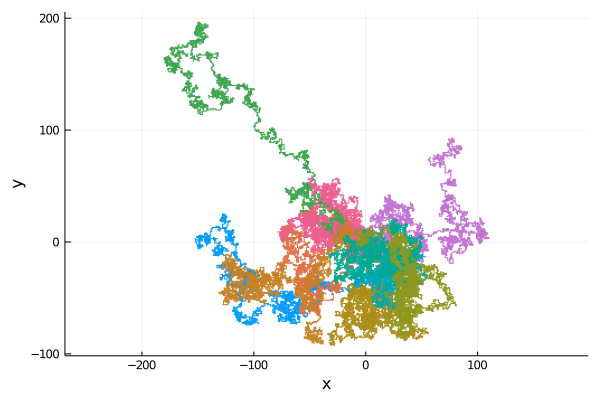

In [19]:
p = plot(leg=:false, xlabel="x", ylabel="y", aspect_ratio=:equal)

for i in 1:num_traj
    plot!(trajectories[i])
end

p

## Exercise 2: Making agents move

In this exercise we will combine our `Agent` type from Problem Set 3 with the 2D random walker that we just created, by adding a position to the `Agent` type.

1. Define a mutable type `Agent` that is a subtype of `AbstractWalker2D` from Exercise 1, since it will behave like a random walker and lives in 2D.

    `Agent` should contain a `position` of type `Location`, as well as a `state` of type `InfectionStatus`.

    (For simplicity we will not require a `num_infected` field, but feel free to do so if you would like.)


2. Agents live in a box of side length `L`, centered at the origin. We need to decide (i.e. model) what happens when they reach the walls of the box (boundaries), i.e. what kind of **boundary conditions** to use.

    One type of boundary condition that is relatively simple to implement are **reflecting boundary conditions**, as follows:

    Each side of the box is a reflective mirror. We can model this using "bounce-back": if the particle tries to jump beyond one of the boundaries, it hits a springy wall and bounces back to the *same* position that it started from. That is, it **proposes** to take a step, but "realises" that it is blocked in that direction, so just stays where it is instead for that step.


    Use the `jump` function from before (that proposes a new position) inside a new
    method of the `jump` function for an `Agent` that also accepts a size `L`
    and implements reflecting boundary conditions.
    It returns a `Location` object representing the new position (inside the grid).

3. Check that this is working by drawing a trajectory of an `Agent` inside a square box of side length 20,
using your function `trajectory` from Exercise 1.

    You should draw the boundaries of the box and also a trajectory that is sufficiently long to see what happens at the boundary, but not so long that it fills up the box.

In [20]:
@enum InfectionStatus S I R

In [21]:
mutable struct Agent <: Abstract2DWalker
    position::Location
    state::InfectionStatus
end

In [22]:
function jump(walker::Agent, L::Int64)
    current_position = pos(walker)
    new_x, new_y = jump(walker)
    if abs(new_x) > L/2 || abs(new_y) > L/2
        new_x, new_y = make_tuple(current_position)
    end
    return Location(new_x, new_y)
end

jump (generic function with 2 methods)

In [23]:
function jump!(walker::Agent, L::Int64)
    new_pos = jump(walker, L)
    set_pos!(walker, new_pos)
    return walker
end

jump! (generic function with 2 methods)

In [24]:
function trajectory(walker::Agent, N::Int64, L::Int64)
    trajectory = [make_tuple(walker.position)]
    for i in 1:N
        jump!(walker, L)
        push!(trajectory, make_tuple(walker.position))
    end
    return trajectory
end

trajectory (generic function with 2 methods)

In [25]:
agent = Agent(Location(0,0), S)

N = 500
L = 20
traj = trajectory(agent, N, L)

501-element Array{Tuple{Int64,Int64},1}:
 (0, 0)
 (1, 0)
 (1, -1)
 (2, -1)
 (1, -1)
 (2, -1)
 (2, -2)
 (2, -3)
 (2, -2)
 (1, -2)
 (0, -2)
 (0, -3)
 (0, -2)
 ⋮
 (-1, 2)
 (0, 2)
 (-1, 2)
 (-1, 1)
 (-1, 2)
 (0, 2)
 (1, 2)
 (1, 1)
 (1, 2)
 (2, 2)
 (2, 3)
 (2, 2)

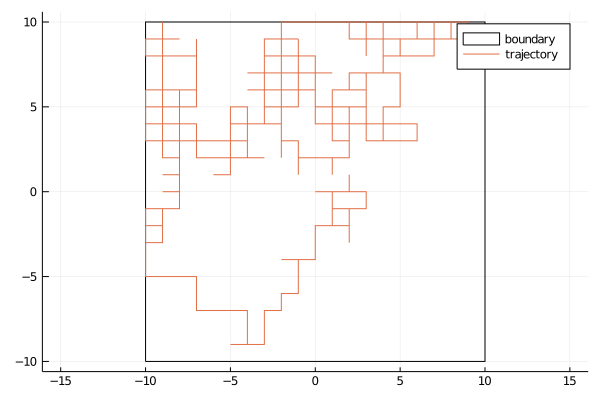

In [26]:
plot(Shape([-10, 10, 10, -10], [-10, -10, 10, 10]), fillcolor=false, aspect_ratio=:equal, label="boundary")
plot!(traj, label="trajectory")

### Exercise 3: Spatial epidemic model  -- Initialization and visualization

We now have all of the technology in place to simulate an agent-based model in space!

For simplicity we will impose in the model that there is at most one agent on each site at all times, modelling the fact that two people cannot be in the same place as each other.

We thus begin by creating an initial condition for $N$ agents that satisfies this. Later we must make sure that the dynamics also respects this.

1. Write a function `initialize` that takes parameters $L$, the side length of the square box where the agents live, and $N$, the number of agents.

    It should build, one by one, a collection of agents, by proposing a position for each one and checking if that position is occupied. If the position is occupied, it should generate another one, and so on until it finds a free spot.

    You may create additional functions to help with this if you find it useful to do so.

    The agents should all have initial status `S`, except for one of them, e.g. the first in the list, which has initial status `I` -- i.e. it is the only source of infection.

    It should return the `Vector` of `Agent`s.

2. Run your initialization function for $L=10$ and $N=20$.

3. Write a function `visualize_agents` that takes in a collection of agents as argument. It should plot a point for each agent, coloured according to its status.

    You can use the keyword argument `c=cs` inside your call to the plotting function to set the colours of points to a vector of integers called `cs`. Don't forget to use `ratio=1`.

4. Run the function to visualize the initial condition you created.

In [27]:
function initialize(L::Int64, N::Int64)
    bdy = Int64(L/2)
    
    position = (rand(-bdy:bdy), rand(-bdy:bdy))
    first_agent = Agent(Location(position...), I)
    
    agents = [first_agent]
    occupied_positions = [position]
    
    for i in 2:N
        while position in occupied_positions
            position = (rand(-bdy:bdy), rand(-bdy:bdy))
        end
        push!(agents, Agent(Location(position...), S))
        push!(occupied_positions, position)
    end
    
    return agents
end

initialize (generic function with 1 method)

In [28]:
L = 10
N = 20

agents = initialize(L, N)

20-element Array{Agent,1}:
 Agent(Location(-4, -1), I)
 Agent(Location(0, -5), S)
 Agent(Location(4, 3), S)
 Agent(Location(-1, 2), S)
 Agent(Location(-3, 2), S)
 Agent(Location(2, 4), S)
 Agent(Location(-4, 2), S)
 Agent(Location(0, 2), S)
 Agent(Location(2, -1), S)
 Agent(Location(-3, 1), S)
 Agent(Location(-5, 0), S)
 Agent(Location(4, 1), S)
 Agent(Location(4, -2), S)
 Agent(Location(-1, -1), S)
 Agent(Location(-3, 3), S)
 Agent(Location(-2, -5), S)
 Agent(Location(-2, 3), S)
 Agent(Location(-3, -2), S)
 Agent(Location(-2, 2), S)
 Agent(Location(5, 4), S)

In [29]:
function visualize_agents(agents::Array{Agent,1})
    colors = ["blue", "red", "green"]
    positions = [make_tuple(agent.position) for agent in agents]
    cs = [colors[Int64(agent.state) + 1] for agent in agents]
    
    scatter(positions, c=cs, ratio=1, leg=:false)
end

visualize_agents (generic function with 1 method)

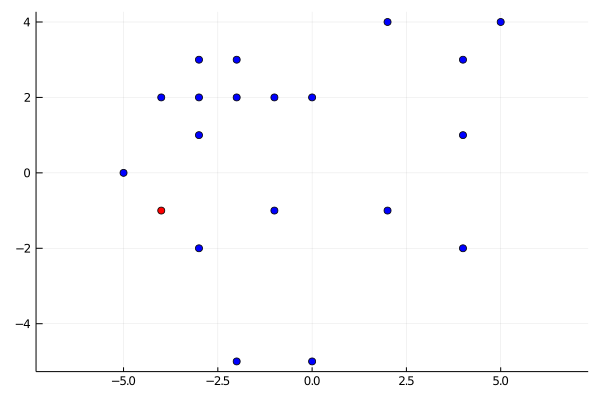

In [30]:
visualize_agents(agents)

### Exercise 4: Spatial epidemic model -- Dynamics

1. Write a function `step!` that does one step of the dynamics of the model.
It takes as parameters $L$, $p_I$ and $p_R$.
This combines what we did in the last Problem Set with the 2D random walker above.

    The rules are as follows:

    - A single agent is chosen at random; call it agent $i$.

    - A new position is proposed for that agent.

    - If that new position is not occupied, the agent moves there.

    - If the new position *is* occupied, by agent $j$, then *neither* of them move, but they interact
    via the following rule:

    - If agent $i$ is infected and agent $j$ is susceptible then agent $j$ becomes infected with probability $p_I$.

    - If  agent $i$ is infected, it recovers with probability $p_R$.

2. Make a small system and run the `step!` function a few times to check (by eye) that it's doing the right thing.

3. Make an interactive visualization to display the agents after each step, to again check visually that the implementation is correct.

4. Write a function `sweep!` that takes the relevant parameters and performs one sweep, i.e. $N$ steps.

5. Write a function `dynamics!` that takes the same parameters as `step!`, together with a number of sweeps.

    Run the dynamics for the given number of sweeps.

    Save the state of the whole system, together with the total numbers of $S$, $I$ and $R$ individuals, after each sweep, for later use.

    You may need the function `deepcopy` to copy the state of the whole system.

6. Given one simulation run, write an interactive visualization that shows both the state at time $n$ (using `visualize_agents`) and the history of $S$, $I$ and $R$ from time $0$ up to time $n$. To do this, make two separate plot objects $p_1$ and $p_2$ and use the $hbox$ or $vbox$ function to put them together horizontally or vertically into a single plot.

7. Using $L=20$ and $N=100$, experiment with $p_I$ and $p_R$ until you find an epidemic outbreak. (Take $p_R$ quite small.)

8. For the values of $p_I$ and $p_R$ that you found in [11],
run 50 simulations. Plot $S$, $I$ and $R$ as a function of time for each of them (with transparency!).

9. Plot their means with error bars.

    You should see a result that looks like all those plots that you've seen of the
    SIR model on the internet. (If you haven't seen any, then what are you waiting for --
    go and find some!)
    Except that they *never show you error bars*, even though error bars are clearly
    *of the utmost importance*.

In [31]:
function step!(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64)
    N = length(agents)
    positions = [agent.position for agent in agents]
    
    # Choose one agent at random
    i = rand(1:N)
    agent = agents[i]
    
    # Propose new position
    new_pos = jump(agent, L)
    # If new position is unoccupied, move there
    if !(new_pos in positions)
        set_pos!(agent, new_pos)
    # Else, neither move and they interact
    else
        j = findall(pos -> pos==new_pos, positions)[1]
        other_agent = agents[j]
        if agent.state == I
            # Chance to infect other agent
            if other_agent.state == S && rand() <= p_I
                other_agent.state = I
            end
            # Chance to recover
            if rand() <= p_R
                agent.state = R
            end
        end
    end
end

step! (generic function with 1 method)

In [32]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5143180317666800741\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6285809228319486253\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5143180317666800741\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [33]:
L = 4
N = 3

p_I = 0.5
p_R = 0.1

agents = initialize(L, N)
num_steps = 100

steps = [deepcopy(agents)]

for i in 1:num_steps
    step!(agents, L, p_I, p_R)
    push!(steps, deepcopy(agents))
end

In [34]:
@manipulate for i in slider(1:num_steps+1, value=1)
    visualize_agents(steps[i])
    plot!(Shape([-10, 10, 10, -10], [-10, -10, 10, 10]), fillcolor=false, aspect_ratio=:equal, label="boundary")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 101,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000112f52890, Task (runnable) @0x0000000112f52890), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\"

In [35]:
function sweep!(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64)
    N = length(agents)
    for i in 1:N
        step!(agents, L, p_I, p_R)
    end
end

sweep! (generic function with 1 method)

In [36]:
function dynamics!(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64, T::Int64)
    sweeps = [deepcopy(agents)]
    Ss = [length(agents) - 1]
    Is = [1]
    Rs = [0]

    for i in 1:T
        sweep!(agents, L, p_I, p_R)
        push!(sweeps, deepcopy(agents))
        push!(Ss, count(agent->agent.state==S, agents))
        push!(Is, count(agent->agent.state==I, agents))
        push!(Rs, count(agent->agent.state==R, agents))
    end
    
    return sweeps, Ss, Is, Rs
end

dynamics! (generic function with 1 method)

In [37]:
function visualize_dynamics(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64, T::Int64)
    sweeps, Ss, Is, Rs = dynamics!(agents, L, p_I, p_R, T)
    
    @manipulate for i in slider(0:T, value=0)
        p_agents = visualize_agents(sweeps[i+1])
        plot!(Shape([-10, 10, 10, -10], [-10, -10, 10, 10]), fillcolor=false, aspect_ratio=:equal, label="boundary")
        xlabel!("x")
        ylabel!("y")
        
        p_dynamics = plot(Ss[1:i+1], c="blue", label="susceptible")
        plot!(Is[1:i+1], c="red", label="infectious")
        plot!(Rs[1:i+1], c="green", label="recovered")
        xlabel!("time (days)")
        ylabel!("number of people")
        
        vbox(p_agents, p_dynamics)
    end
end

visualize_dynamics (generic function with 1 method)

In [38]:
L = 20
N = 100
agents = initialize(L, N)

p_I = 0.1
p_R = 0.005
T = 1000

visualize_dynamics(agents, L, p_I, p_R, T)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010f0d8490, Task (runnable) @0x000000010f0d8490), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"

In [39]:
num_sims = 50

Sss = [zeros(T) for i in 1:num_sims]
Iss = [zeros(T) for i in 1:num_sims]
Rss = [zeros(T) for i in 1:num_sims]

for i in 1:num_sims
    agents = initialize(L, N)
    sweeps, Ss, Is, Rs = dynamics!(agents, L, p_I, p_R, T)
    
    Sss[i] = Ss
    Iss[i] = Is
    Rss[i] = Rs
end

In [40]:
p = plot(xlabel="time (days)", ylabel="number of people", leg=:false)
for i in 1:num_sims
    plot!(Sss[i], alpha=0.25, color="blue")
    plot!(Iss[i], alpha=0.25, color="red")
    plot!(Rss[i], alpha=0.25, color="green")
end

p

In [41]:
using Statistics

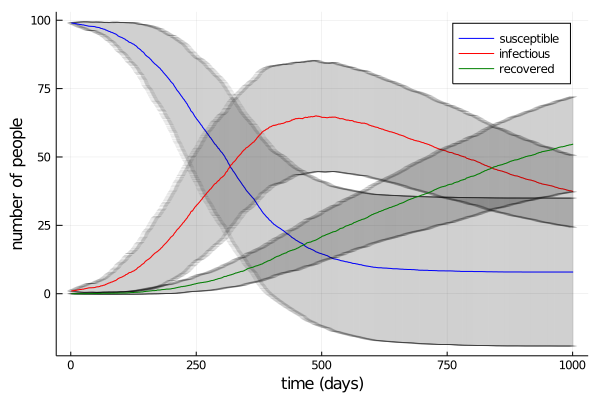

In [42]:
mean_Ss = mean(Sss)
mean_Is = mean(Iss)
mean_Rs = mean(Rss)

std_Ss = std(Sss)
std_Is = std(Iss)
std_Rs = std(Rss)

p = plot(xlabel="time (days)", ylabel="number of people")
plot!(mean_Ss, yerr=std_Ss, alpha=0.1, linecolor=false, label=false)
plot!(mean_Ss, color="blue", label="susceptible")
plot!(mean_Is, yerr=std_Is, alpha=0.1, linecolor=false, label=false)
plot!(mean_Is, color="red", label="infectious")
plot!(mean_Rs, yerr=std_Rs, alpha=0.1, linecolor=false, label=false)
plot!(mean_Rs, color="green", label="recovered")

### Exercise 5 (Extra credit -- or for summer vacation): Social distancing

We can use a variant of the above model to investigate the effect of the
totally mis-named "social distancing"  
(we want people to be socially *close*, but *physically* distant).

In this variant, we separate out the two effects "infection" and
"movement": an infected agent chooses a
neighbouring site, and if it finds a susceptible there then it infects it
with probability $p_I$.

Separately, an agent chooses a neighbouring site to move to,
moves there with probability $p_M$ if the site is vacant. (Otherwise it
stays where it is.)

1. When $p_M = 0$, the agents cannot move, and hence are
completely quarantined in their original locations.
Where can the disease spread in this case?

    Run the dynamics repeatedly, looking at which sites become infected.
    (Draw them!)

    How does this change as you increase the *density*
    $\rho = N / (L^2)$ of agents?  Start with a small density.

    This is basically the [**site percolation**](https://en.wikipedia.org/wiki/Percolation_theory)
    model.

2. When we start to increase $p_M$, we allow some local motion via random walk.
Investigate how this leaky quarantine affects the infection dynamics with
different densities.

In [120]:
function step!(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64, p_M::Float64)
    N = length(agents)
    positions = [agent.position for agent in agents]
    
    # Infection step
    # Choose one infected agent
    inds_I = findall(agent -> agent.state == I, agents)
    if length(inds_I) != 0
        i = rand(inds_I)
        infected_agent = agents[i]
        # If neighbor is susceptible, chance to infect
        neighbor = jump(infected_agent, L)
        if neighbor in positions
            j = findall(pos -> pos==neighbor, positions)[1]
            other_agent = agents[j]
            if other_agent.state == S && rand() <= p_I
                other_agent.state = I
            end
        end
    end
    
    # Movement step
    # Choose random agent to move
    i = rand(1:N)
    movement_agent = agents[i]
    new_pos = jump(movement_agent, L)
    if !(new_pos in positions) && rand() <= p_M
        set_pos!(movement_agent, new_pos)
    end
end

step! (generic function with 2 methods)

In [121]:
function sweep!(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64, p_M::Float64)
    N = length(agents)
    for i in 1:N
        step!(agents, L, p_I, p_R, p_M)
        # Chance to recover
        if agents[i].state == I && rand() <= p_R
            agents[i].state = R
        end
    end
end

sweep! (generic function with 2 methods)

In [122]:
function dynamics!(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64, p_M::Float64, T::Int64)
    sweeps = [agents for i in 1:T+1]
    sweeps[1] = deepcopy(agents)
    Ss = zeros(Int64, T+1)
    Ss[1] = length(agents) - 1
    Is = zeros(Int64, T+1)
    Is[1] = 1
    Rs = zeros(Int64, T+1)
    
    for i in 1:T
        sweep!(agents, L, p_I, p_R, p_M)
        sweeps[i+1] = deepcopy(agents)
        Ss[i+1] = count(agent->agent.state==S, agents)
        Is[i+1] = count(agent->agent.state==I, agents)
        Rs[i+1] = count(agent->agent.state==R, agents)
    end
    
    return sweeps, Ss, Is, Rs
end

dynamics! (generic function with 2 methods)

In [123]:
function visualize_dynamics(agents::Vector{Agent}, L::Int64, p_I::Float64, p_R::Float64, p_M::Float64, T::Int64)
    sweeps, Ss, Is, Rs = dynamics!(agents, L, p_I, p_R, p_M, T)
    
    @manipulate for i in slider(0:T, value=0)
        p_agents = visualize_agents(sweeps[i+1])
        plot!(Shape([-10, 10, 10, -10], [-10, -10, 10, 10]), fillcolor=false, aspect_ratio=:equal, label="boundary")
        xlabel!("x")
        ylabel!("y")
        
        p_dynamics = plot(Ss[1:i+1], c="blue", label="susceptible")
        plot!(Is[1:i+1], c="red", label="infectious")
        plot!(Rs[1:i+1], c="green", label="recovered")
        xlabel!("time (days)")
        ylabel!("number of people")
        
        vbox(p_agents, p_dynamics)
    end
end

visualize_dynamics (generic function with 2 methods)

In [137]:
L = 20
N = 100

p_I = 0.1
p_R = 0.01

p_M = 0.0

T = 1000;

In [138]:
agents = initialize(L, N)
visualize_dynamics(agents, L, p_I, p_R, p_M, T)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000133764fd0, Task (runnable) @0x0000000133764fd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"

In [139]:
p_M = 0.01;

In [140]:
agents = initialize(L, N)
visualize_dynamics(agents, L, p_I, p_R, p_M, T)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000133765b10, Task (runnable) @0x0000000133765b10), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"

In [141]:
p_M = 0.1;

In [142]:
agents = initialize(L, N)
visualize_dynamics(agents, L, p_I, p_R, p_M, T)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000133765f90, Task (runnable) @0x0000000133765f90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"

In [143]:
p_M = 0.5
agents = initialize(L, N)
visualize_dynamics(agents, L, p_I, p_R, p_M, T)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000133766650, Task (runnable) @0x0000000133766650), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"

In [144]:
p_M = 1.0
agents = initialize(L, N)
visualize_dynamics(agents, L, p_I, p_R, p_M, T)

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 1000,:min => 0,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
0, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000133766f50, Task (runnable) @0x0000000133766f50), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"

In [152]:
L = 20
N = 100

p_I = 0.1
p_R = 0.01

T = 1000

@manipulate for p_M in slider([0.0, 0.01, 0.1, 0.5, 1.0], value=1.0, label="probability of movement")
    agents = initialize(L, N)
    sweeps, Ss, Is, Rs = dynamics!(agents, L, p_I, p_R, p_M, T)

    p_dynamics = plot(Ss, c="blue", label="susceptible")
    plot!(Is, c="red", label="infectious")
    plot!(Rs, c="green", label="recovered")
    xlabel!("time (days)")
    ylabel!("number of people")
    
    p_dynamics
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["probability of movement"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 5,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
5, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/work/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/work/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/work/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000015cd9c010, Task (runnable) @0x000000015cd9c010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.01\",\"0.1\",\"0.5\",\"1.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"2580320041068293675\",\"id\":\"8083642738271955605\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"